## Load Packages

In [1]:
using Dates, DelimitedFiles, Statistics 

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
    default(fmt = :png)
end

# The Theoretical Predictions of CAPM

The following section illustrates the theoretical predictions of CAPM by taking the following steps: 
1. define a set of investable assets
2. find the tangency portfolio
3. calculate the betas of each asset against the tangency portfolio
4. check whether the average returns are in accordance with CAPM.

## Characteristics of Three Assets: Means and Covariances

In [4]:
μ = [0.115; 0.095; 0.06]    #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

println("expected returns: ")
printmat(μ)
println("covariance matrix:")
printmat(Σ)

expected returns: 
     0.115
     0.095
     0.060

covariance matrix:
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010



## The Tangency Portfolio

The function for the tangency portfolio is from the chapter on mean-variance analysis.

In [5]:
function MVTangencyP(μ,Σ,Rf)           #calculates the tangency portfolio
    n     = length(μ)
    oneV  = ones(n)  
    μe    = μ .- Rf                    #expected excess returns            
    Σ_1   = inv(Σ)
    w     = Σ_1 * μe/(oneV'Σ_1*μe)
    muT   = w'μ + (1-sum(w))*Rf
    StdT  = sqrt(w'Σ*w)
    return w,muT,StdT
end

MVTangencyP (generic function with 1 method)

In [6]:
(wT,muT,StdT) = MVTangencyP(μ,Σ,Rf)
println("\nTangency portfolio: ")
printmat(wT)


Tangency portfolio: 
     0.248
     0.682
     0.070



## (Theoretical) β of the Assets

The tangency portfolio is a portfolio of the investable assets ($R_T=w_T'R$). It is therefore straightforward to calculate the covariance (and betas) of $R_T$ with each of the assets.

Details: 

$\textrm{Cov}(R_i,R_T) = w_i'\Sigma w_T$, and $\beta_i = \textrm{Cov}(R_i,R_T)/\textrm{Var}(R_T)$.

In [7]:
n = length(μ)                      #no. assets

β     = fill(NaN,n)
for i = 1:n
    local wi, CovRim
    wi     = zeros(n)
    wi[i]  = 1                      #weight 1 on asset i
    CovRim = wi'Σ*wT
    β[i]   = CovRim/StdT^2          #usual OLS coefficient
end    
println("\nβ of the $n assets: ")
printmat(β)


β of the 3 assets: 
     1.259
     0.963
     0.444



## Trying CAPM on the Three Assets

Recall: CAPMS says

$\textrm{E}R_{i}  = R_f + \beta_{i}(\mu_{T}-R_f)$
 
This can be compared with the (actual) average returns. 

In [8]:
ERi_CAPM = Rf .+ β*(muT-Rf)      #vector since β is

println("\nμ and as suggested by CAPM: ")
printmat([μ ERi_CAPM])


μ and as suggested by CAPM: 
     0.115     0.115
     0.095     0.095
     0.060     0.060



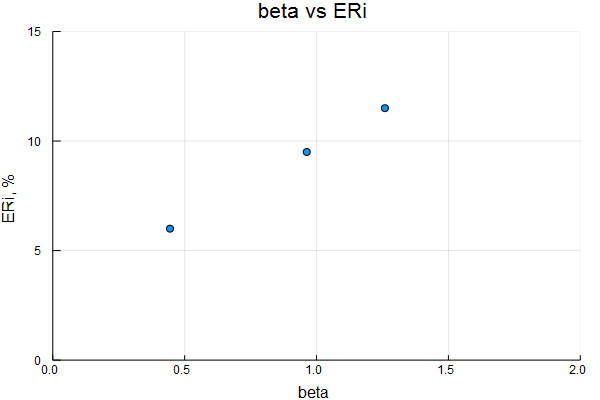

In [9]:
p1 = scatter(β,ERi_CAPM*100,xlim=(0,2),ylim=(0,15),legend=false)
title!(p1,"beta vs ERi")
xlabel!(p1,"beta")
ylabel!(p1,"ERi, %")
display("image/png",p1)

# An Empirical Test of CAPM 

The next section performs an empirical test of CAPM. First, we load data. Second, we run linear regressions and test whether the intercept is zero (the CAPM prediction) or not.

## Loading Data

In [10]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1;7;13;19;25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                 #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

We now use the market return as a proxy for the tangency portfolio - and test if the model holds.

Recall: estimate $(\alpha_{i},b_{i})$ in the CAPM regression

$R_{it}^{e}  =\alpha_{i}+b_{i}R_{mt}^{e}+\varepsilon_{it}$

Test if $\alpha_{i}=0$

Under the Gauss-Markov assumptions, $\textrm{Cov}(\alpha_{i},b_{i}) = (X'X)^{-1}\textrm{Var}(\varepsilon_{it})$,
where row $t$ of $X$ contains $[1, R_{mt}^e]$. Use element [1,1] of the covariance matrix as the variance of the $\alpha_i$ estimate.

In [11]:
x   = [ones(T) Rme]                   #regressors
Σ_1 = inv(x'x)

α     = fill(NaN,n)
tstat = fill(NaN,n)
for i = 1:n                              #loop over the different test assets
    local b_i, residual, Covb
    b_i       = x\Re[:,i]                #OLS
    residual  = Re[:,i] - x*b_i
    α[i]      = b_i[1]                   #estimated α
    Covb      = Σ_1*var(residual)   
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])  #tstat of H₀: true α=0
end    
println("\nOLS intercepts and t-stats, regressing Re on constant and Rme")
printmat([α tstat])


OLS intercepts and t-stats, regressing Re on constant and Rme
    -0.504    -1.656
     0.153     1.031
     0.305     2.471
     0.279     2.163
     0.336     2.073

